##### Grading Feedback Cell
94%

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.__

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
from pyspark.sql.functions import isnan, isnull, when, count, col
from pyspark.sql import functions as fn
import matplotlib.pyplot as plt
from pyspark.mllib.stat import Statistics
from pyspark.ml import feature
from pyspark.ml import clustering
# Functionality for regression
from pyspark.ml import regression
# Funcionality for classification
from pyspark.ml import classification
# Object for creating sequences of transformations
from pyspark.ml import Pipeline
import seaborn as sns
from pyspark.ml.feature import StandardScaler
from math import exp, log10, fabs, atan, log
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import requests
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF

The following cell is used to determine if the environment is databricks or personal computer and determine the correct data file path accordingly.

In [9]:
# Do not delete or change this cell

import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

# Unsupervised learning

The colleges_data_science_programs dataset contains information about dozens of "data science" programs across the US.

## Question 1: (10 pts)

This dataset contains many columns that we can use to understand how these data science programs differ from one another.

## Question 1a (5 pts)
Using get_training_filename, read the colleges_data_science_programs.csv data file into a data frame named raw_ds_programs_text_df.  Print the head of the raw_ds_programs_text_df using Pandas, and the shape using spark.

In [10]:
# Your code here
raw_ds_programs_text_df = get_training_filename('colleges_data_science_programs.csv')
raw_ds_programs_text_df = spark.read.csv(raw_ds_programs_text_df, header=True, inferSchema=True)


#head and shape
print(f"No of rows and columns in spam_df:({raw_ds_programs_text_df.count()},{len(raw_ds_programs_text_df.columns)})")
raw_ds_programs_text_df.toPandas().head(5)

No of rows and columns in spam_df:(222,28)


,id,name,url,program,degree,country,state,online,oncampus,department,...,cost,visualization,machine learning,business,databases,programminglanguages,capstone,mapreduce,part-time,ethics
0,1,South Dakota State University,http://www.sdstate.edu/mathstat/grad/masters-i...,Data Science,Masters,US,SD,False,True,Mathematics and Statistics,...,None,None,None,None,None,None,None,None,None,None
1,2,Dakota State University,http://www.dsu.edu/msa/,Analytics,Masters,US,SD,True,True,Business and Information Systems,...,None,None,None,None,None,None,None,None,None,None
2,3,Lewis University,http://www.lewisu.edu/academics/data-science/i...,Data Science,Masters,US,IL,True,True,Computer Science,...,None,None,None,None,None,None,None,None,None,None
3,4,Saint Joseph's University,http://online.sju.edu/programs/business-intell...,Business Intelligence & Analytics,Masters,US,PA,True,True,Business,...,None,None,None,None,None,None,None,None,None,None
4,5,University Of Leeds,http://www.engineering.leeds.ac.uk/computing/p...,Advanced Computer Science(Data Analytics),Masters,GB,None,False,True,Computer Science,...,None,None,None,None,None,None,None,None,None,None


##### Grading Feedback Cell

## Question 1b (5 pts)
Starting with `raw_ds_programs_text_df`, create a new dataframe named`ds_programs_text_df` which simply adds a column `text` to the dataframe `raw_ds_programs_df`. This column will have the concatenation of the following columns separated by a space: `program`, `degree` and `department` (find the appropriate function in the `fn` package). <br>

An example of the `ds_programs_text_df` should give you:

```python
ds_programs_text_df.orderBy('id').first().text
```

```console
'Data Science Masters Mathematics and Statistics'
```
<br>
- Print the head of the raw_ds_programs_text_df using Pandas, and the shape using spark.<br>
- Print the text column in the first row of the ds_programs_text_df.

In [11]:
# Your code here
#ds_programs_text_df = raw_ds_programs_text_df.withColumn('text',fn.concat(fn.col('program'),fn.lit(' '), fn.col('degree'),fn.lit(' '), fn.col('department')))
ds_programs_text_df = raw_ds_programs_text_df.withColumn("text",fn.concat_ws(' ',raw_ds_programs_text_df.program,raw_ds_programs_text_df.degree,raw_ds_programs_text_df.department))
#Printing head and shape
print(f"No of rows and columns in spam_df:({ds_programs_text_df.count()},{len(ds_programs_text_df.columns)})")
ds_programs_text_df.toPandas().head(3)


No of rows and columns in spam_df:(222,29)


,id,name,url,program,degree,country,state,online,oncampus,department,...,visualization,machine learning,business,databases,programminglanguages,capstone,mapreduce,part-time,ethics,text
0,1,South Dakota State University,http://www.sdstate.edu/mathstat/grad/masters-i...,Data Science,Masters,US,SD,False,True,Mathematics and Statistics,...,None,None,None,None,None,None,None,None,None,Data Science Masters Mathematics and Statistics
1,2,Dakota State University,http://www.dsu.edu/msa/,Analytics,Masters,US,SD,True,True,Business and Information Systems,...,None,None,None,None,None,None,None,None,None,Analytics Masters Business and Information Sys...
2,3,Lewis University,http://www.lewisu.edu/academics/data-science/i...,Data Science,Masters,US,IL,True,True,Computer Science,...,None,None,None,None,None,None,None,None,None,Data Science Masters Computer Science


In [12]:
#checking the outcome
ds_programs_text_df.orderBy('id').first().text

'Data Science Masters Mathematics and Statistics'

##### Grading Feedback Cell

# Question 2: (10 pts) 

## Question 2a (5 pts)
Create a pipeline named `pipe_features` that creates a new dataframe `ds_features_df`.  The pipe_features pipeline adds a column `features` to `ds_programs_text_df` that contains the `tfidf` of the `text` column.  Print the head of ds_features_df using Pandas and print the shape using spark.

In [13]:
# Create ds_programs_text_df here
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
tokenizer = RegexTokenizer().setGaps(False).setPattern("\\p{L}+").setInputCol("text").setOutputCol("words")

remover = StopWordsRemover().setStopWords(stop_words).setCaseSensitive(False).setInputCol("words").setOutputCol("filtered_text")

cv = CountVectorizer().setInputCol("filtered_text").setOutputCol("tf")
idf = IDF().setInputCol('tf').setOutputCol('features')


cols = ds_programs_text_df.columns[:]
pipe_features = Pipeline(stages=[tokenizer,remover,cv,idf]).fit(ds_programs_text_df)
ds_features_df = pipe_features.transform(ds_programs_text_df).select(*cols,'features')


print("Shape of ds_features_df is: ",(ds_features_df.count(), len(ds_features_df.columns)))
ds_features_df.toPandas().head()

Shape of ds_features_df is:  (222, 30)


,id,name,url,program,degree,country,state,online,oncampus,department,...,machine learning,business,databases,programminglanguages,capstone,mapreduce,part-time,ethics,text,features
0,1,South Dakota State University,http://www.sdstate.edu/mathstat/grad/masters-i...,Data Science,Masters,US,SD,False,True,Mathematics and Statistics,...,None,None,None,None,None,None,None,None,Data Science Masters Mathematics and Statistics,"(0.2538801769623398, 0.6622396430968687, 0.0, ..."
1,2,Dakota State University,http://www.dsu.edu/msa/,Analytics,Masters,US,SD,True,True,Business and Information Systems,...,None,None,None,None,None,None,None,None,Analytics Masters Business and Information Sys...,"(0.2538801769623398, 0.0, 1.0377239189930973, ..."
2,3,Lewis University,http://www.lewisu.edu/academics/data-science/i...,Data Science,Masters,US,IL,True,True,Computer Science,...,None,None,None,None,None,None,None,None,Data Science Masters Computer Science,"(0.2538801769623398, 0.6622396430968687, 0.0, ..."
3,4,Saint Joseph's University,http://online.sju.edu/programs/business-intell...,Business Intelligence & Analytics,Masters,US,PA,True,True,Business,...,None,None,None,None,None,None,None,None,Business Intelligence & Analytics Masters Busi...,"(0.2538801769623398, 0.0, 2.0754478379861947, ..."
4,5,University Of Leeds,http://www.engineering.leeds.ac.uk/computing/p...,Advanced Computer Science(Data Analytics),Masters,GB,None,False,True,Computer Science,...,None,None,None,None,None,None,None,None,Advanced Computer Science(Data Analytics) Mast...,"(0.2538801769623398, 0.6622396430968687, 0.0, ..."


##### Grading Feedback Cell
-3 Runtime error fixed by grader

## Question 2b (5 pts)
Create a pipeline model `pipe_pca` that computes the two first principal components of the `features` column as computed by `pipe_features` and creates a column named `scores`. Use that pipeline to create a dataframe `ds_features_df` with the columns `id`, `name`, `url`, and `scores`.

In [14]:
# create ds_features_df here
pipe_pca = Pipeline(stages=[feature.StandardScaler(withMean=True,withStd = False,inputCol='features', outputCol='f'),
                            feature.PCA(k=2, inputCol='f', outputCol='scores')]).fit(ds_features_df)

ds_features_df2 = pipe_pca.transform(ds_features_df).select('id','name','url','scores')
ds_features_df2.toPandas().head(5)

,id,name,url,scores
0,1,South Dakota State University,http://www.sdstate.edu/mathstat/grad/masters-i...,"[-0.28936530400146304, 1.225874242754145]"
1,2,Dakota State University,http://www.dsu.edu/msa/,"[-0.3179830950693028, 0.9026154588118561]"
2,3,Lewis University,http://www.lewisu.edu/academics/data-science/i...,"[-0.019973100053756465, 0.21391827433862404]"
3,4,Saint Joseph's University,http://online.sju.edu/programs/business-intell...,"[-0.7162195133606062, -1.3984845319290018]"
4,5,University Of Leeds,http://www.engineering.leeds.ac.uk/computing/p...,"[-0.10536845675883032, 0.0665491080878871]"


##### Grading Feedback Cell

# Question 3: (10 pts)

Create a scatter plot with the x axis containing the first principal component (loading) and the y axis containing the second principal component (loading) of `ds_features_df`

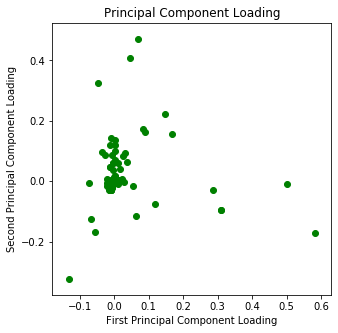

In [15]:
# Your code here
loadings = pipe_pca.stages[-1].pc.toArray()
c_loading_1 = loadings[:,0]
c_loading_2 = loadings[:,1]

plt.figure(figsize=(5,5))
plt.scatter(c_loading_1,c_loading_2,color='green')

plt.xlabel('First Principal Component Loading')
plt.ylabel('Second Principal Component Loading')
plt.title('Principal Component Loading')
plt.show()

##### Grading Feedback Cell

# Question 4 (10 pts)

Create two Pandas dataframes `pc1_pd` and `pc2_pd` with the columns `word` and `abs_loading` that contain the top 5 words and absolute loadings for the principal components 1 and 2, respetively.  Print both dataframes. Interpret the loadings.

In [16]:
# your code here (5 pts)

vocab = list(pipe_features.stages[2].vocabulary)
c_loading_1 = abs(c_loading_1)
c_loading_2 = abs(c_loading_2)

pc1 = {'word':vocab,'abs_loading':c_loading_1}
pc1_pd = pd.DataFrame(pc1)
pc1_pd = pc1_pd.sort_values('abs_loading',ascending = False).head(5)

pc2 = {'word':vocab,'abs_loading':c_loading_2}
pc2_pd = pd.DataFrame(pc2)
pc2_pd = pc2_pd.sort_values('abs_loading',ascending = False).head(5)

print(pc1_pd)
print(pc2_pd)

             word  abs_loading
18  computational     0.582605
14       sciences     0.499972
35      astronomy     0.309639
36        physics     0.309639
22         school     0.285775
           word  abs_loading
7   information     0.472225
21    computing     0.407430
6    statistics     0.325734
2      business     0.324424
15    doctorate     0.224299


##### Grading Feedback Cell

Your interpretation here (5 pts): Loadings that are most important for PCs alongwith variance are given.

##### Grading Feedback Cell
The loading vector coefficients represent covariance between the words and the loading vector if withStd=False in the standard scaler.  If withStd=True, the loading vector coefficients would represent correlation between the words and the loading vector.

# Question 5: (10 pts)

Create a new pipeline for PCA called `pipe_pca2` where you fit 50 principal components. Extract the `PCAModel` from the stages of this pipeline, and assign to a variable named `explainedVariance` which represents the variance explained by components of the model. Finally, assign to a variable named `best_k` the value $k$ such that ($k+1$)-th component is not able to explain more than 0.01 variance. You can use a for-loop to find such best k.  The value best_k should be be 0 based - in other words present best_k assuming that you started counting at 0.

In [17]:
# your code here
# your code here
pipe_pca2 = Pipeline(stages=[feature.StandardScaler(withMean=True,withStd = False,inputCol='features', outputCol='f'),
                            feature.PCA(k=50, inputCol='f', outputCol='scores')]).fit(ds_features_df)

explainedVariance = pipe_pca2.stages[-1].explainedVariance

for i,val in enumerate(explainedVariance):
    if val < 0.01:
        best_k = i-1
        break
print(best_k)

29


##### Grading Feedback Cell

# Question 6: (10 pts)

Create a new pipeline for PCA called pipe_pca3 (similar to pipe_pca2 above) where you fit the maximum possible number of principal components for this dataset. Create a scree plot and a plot of cumulative variance explained.

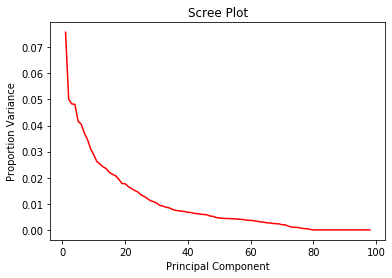

In [18]:
# your code here
pipe_pca3 = Pipeline(stages=[feature.StandardScaler(withMean=True,withStd = False,inputCol='features', outputCol='f'),
                            feature.PCA(k=len(pipe_features.stages[2].vocabulary), inputCol='f', outputCol='scores')]).fit(ds_features_df)
e_V3 = pipe_pca3.stages[-1].explainedVariance

plt.plot(np.arange(1, len(e_V3)+1),e_V3,color='red')
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance")
plt.show()



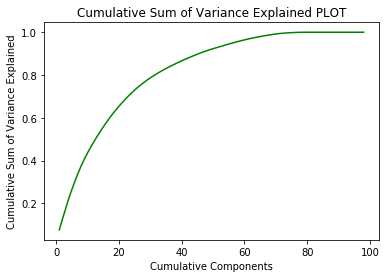

In [21]:
cum_sum = np.cumsum(e_V3)

plt.plot(np.arange(1, len(e_V3)+1), cum_sum,color='green')

plt.title("Cumulative Sum of Variance Explained PLOT")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")
plt.show()

##### Grading Feedback Cell
-3: Runtime Error fixed by grader

# Question 7: (10 pts)
Create a pipeline named pipe_pca4 (similar to pipe_pca3 above) that computes the first 2 principal components.  Add a kmeans objects to the end of pipe_pca4 and compute kmeans with k = 5.  Create a scatter plot PC2 vs. PC1 where each scatter dot is colored by the cluster assignment.  Include a plot legend.

[4]
[4, 4, 4, 0, 4, 0, 4, 0, 0, 0, 2, 4, 4, 0, 1, 3, 0, 1, 3, 4, 0, 0, 3, 1, 3, 4, 0, 3, 4, 2, 4, 4, 4, 2, 0, 0, 0, 3, 4, 0, 4, 0, 4, 2, 4, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 2, 3, 2, 2, 1, 0, 1, 4, 3, 3, 0, 3, 3, 1, 4, 1, 0, 1, 0, 0, 0, 1, 0, 3, 0, 1, 0, 0, 2, 0, 4, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 2, 0, 3, 4, 3, 3, 3, 0, 3, 0, 0, 3, 3, 3, 0, 3, 0, 0, 0, 4, 0, 4, 3, 3, 0, 2, 1, 3, 3, 0, 4, 3, 0, 1, 1, 1, 2, 1, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 4, 0, 0, 3, 4, 4, 0, 0, 0, 4, 0, 0, 4, 1, 4, 2, 2, 2, 3, 0, 1, 2, 0, 0, 0, 0, 4, 4, 3, 0, 3, 0, 3, 0, 1, 0, 1, 3, 0, 2, 2, 0, 1, 1, 4, 3, 0, 1, 1, 2, 0, 0, 0, 0, 0, 1, 4, 0, 3, 2, 0, 4, 3, 3, 3, 0, 2, 3, 3, 0, 0, 2, 1, 1]


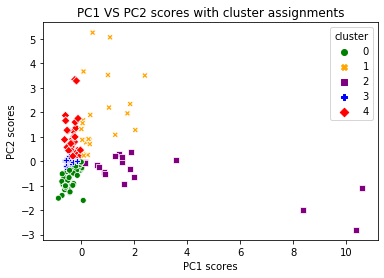

In [26]:
# your code here
# your code here
center = feature.StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='c_features')

pca = feature.PCA(k=2, inputCol='c_features', outputCol='p_features')
norm = feature.Normalizer(inputCol="p_features", outputCol="norm_features", p=2.0)

kmeans = clustering.KMeans(k=5, featuresCol='norm_features', predictionCol='kmeans_features')


pipe_pca4 = Pipeline(stages=[center,pca,norm,kmeans]).fit(ds_features_df)
pipe_pca4_df = pipe_pca4.transform(ds_features_df).select('p_features', 'kmeans_features')



cluster_assignment = pipe_pca4_df.select('kmeans_features').collect()
#print(cluster_assignment)
clusters = [cluster_assignment[0].kmeans_features]
print(clusters)
for i in range(1,len(cluster_assignment)):
    clusters.append(cluster_assignment[i].kmeans_features)
print(clusters)
pca_scores_raw = pipe_pca4_df.select('p_features').collect()

PC1 = [pca_scores_raw[0].p_features[0]]
for i in range(1,len(pca_scores_raw)):
    PC1.append(pca_scores_raw[i].p_features[0])

PC2 = [pca_scores_raw[0].p_features[1]]
for i in range(1,len(pca_scores_raw)):
    PC2.append(pca_scores_raw[i].p_features[1])

import seaborn as sns
g = sns.scatterplot(x=PC1, y=PC2,hue=clusters,legend='full',palette=['green','orange','purple','blue','red'], style =clusters)
plt.title("PC1 VS PC2 scores with cluster assignments")
plt.xlabel("PC1 scores")
plt.ylabel("PC2 scores")
g.get_legend().set_title('cluster')
display()

##### Grading Feedback Cell

# Question 8: (10 pts)
Starting with pipe_pca2, transform the pipeline and save the resulting dataframe to a variable named `pca_fun`.  Extract the output from the standard scaler column from the first row of pca_fun and store in a variable called `z`. Manually compute 10 PCA scores by projecting z onto the first 10 loading vectors. Save the 10 projected pca scores in a varialbe called `projection`.  Extract the first 10 PCA scores from the first row of pca_fun and save them in a variable named `model_scores`.  Print `projection` and `model_scores`.  Compare `projection` to `model_scores` and explain why they are the same or different. 

In [27]:
# your code here (5 pts)
# your code here (5 pts)


pca_fun = pipe_pca2.transform(ds_features_df)

z = pca_fun.select('f').first()['f']

loadings_pipe_pca2 = pipe_pca2.stages[-1].pc.toArray()

projection = z.dot(loadings_pipe_pca2[:,0:10])
print("10 PCA Projection Scores:\n",projection)

model_scores = pca_fun.select('scores').first()['scores'][0:10]
print("10 PCA Model Scores are:\n",model_scores)

10 PCA Projection Scores:
 [-0.2893653   1.22587424 -1.32547104 -0.43764664  0.44087571 -1.07801359
 -1.46592373  0.31262874  0.11687763 -0.33874958]
10 PCA Model Scores are:
 [-0.2893653   1.22587424 -1.32547104 -0.43764664  0.44087571 -1.07801359
 -1.46592373  0.31262874  0.11687763 -0.33874958]


##### Grading Feedback Cell

Your explanation here (5 pts): Both are similar because when loading vectors are multiplied with observations the result is pca scores. 

##### Grading Feedback Cell

# Question 9: (10 pts)
Using PCA loading vectors, perform an inverse transform on the `projection` variable and store the result in a variable named inverse.  Print `inverse` and the original `z` data.  Explain why the inverse data is the same as `z` (or really close to `z`), or why it is different than `z`.  

In [28]:
# your code here (5 pts)
np.set_printoptions(suppress=True)
inverse = loadings_pipe_pca2[:,:10].dot(projection[:])
inverse

array([-0.04834957,  0.23389233, -0.69576894, -0.21105114,  0.44362903,
       -0.01112868,  2.06221089, -0.30537735, -0.39426726,  0.02064218,
        0.2939959 , -0.02173384, -0.11801996,  0.23064638, -0.13921884,
        0.17301953, -0.12390395, -0.12390395, -0.12403536, -0.29310009,
       -0.22589179,  0.22404521, -0.35696817,  0.13443261, -0.17678547,
       -0.17071663,  0.26061751,  0.05600481, -0.09886341,  0.4930084 ,
        0.86719743, -0.01279271, -0.017631  ,  0.05716824, -0.01621876,
       -0.1174412 , -0.1174412 ,  0.0096965 , -0.08597468, -0.04560082,
        0.0139347 , -0.01701422,  0.01578073, -0.00025251, -0.09974429,
        0.23357274, -0.0432366 , -0.07420458, -0.07560859,  0.007687  ,
        0.04998189,  0.00425463, -0.06376777, -0.07560859, -0.214251  ,
       -0.06100712,  0.0132183 , -0.05681794,  0.00417634,  0.00032569,
       -0.1071255 , -0.04575418,  0.04964529,  0.04964529, -0.05681794,
       -0.0470968 , -0.04046285, -0.07763752, -0.0369697 , -0.02

In [29]:
print(z)

[0.057180220036563034,0.29830614553912993,-0.500164231226403,-0.36213126221273584,0.8302945209178554,-0.24098572336347818,2.1616056760509887,-0.23897148177448116,-0.21909331387449488,-0.20638446153250645,-0.19968103721300093,-0.2086993319516678,-0.19710492462101953,-0.17021487380635458,-0.17923925133324392,-0.16209679163956386,-0.14479692044321307,-0.14479692044321307,-0.1590514375466797,-0.13984624677775104,-0.13555299543521387,-0.144592215951527,-0.13555299543521387,-0.10492843066874764,-0.10492843066874764,-0.10492843066874764,-0.0935476114163461,-0.09771384600627199,-0.08142820500522666,3.533984097226837,-0.08142820500522666,-0.0684276370995679,-0.0684276370995679,-0.0684276370995679,-0.05433618122081389,-0.05433618122081389,-0.05433618122081389,-0.05433618122081389,-0.05433618122081389,-0.03881585119632441,-0.03881585119632441,-0.03881585119632441,-0.03881585119632441,-0.03881585119632441,-0.03881585119632441,-0.03881585119632441,-0.03881585119632441,-0.03881585119632441,-0.038815

##### Grading Feedback Cell

Your explanation here (5 pts): The values are different since only 10 loading vectors were used for projection calculation.If more loading vectors are included more similar values can be obtained.

##### Grading Feedbck Cell

# Question 10: (10 pts)

Think about the cumulative variance and the scree plot from the question above.  If you were building a machine learning model, how many principal components would you pick for your model.  Explain why.  

Your Answer Here: The scree plot shows a large change in slopes at the 30th eigenvalue. From the graph of the cumulative proportions, you can see that the first 30 PCs explain 80-85% of the cumulative variance in the data.30-31 is a good number for PCA.


##### Grading Feedback Cell